In [13]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from random import randrange
import pylab
import sklearn.linear_model as lm

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [9]:
# Problem 1
for letter_i in range(10):
    letter = chr(ord('A') + letter_i)
    directory_name = "/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_small/" + letter
    files = os.listdir(directory_name)
    display(Image(filename=os.path.join(directory_name,files[randrange(len(files))])))

In [2]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file, mode='F').astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image (%s) shape: %s' % (image_file, str(image_data.shape)))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_folder_name = "/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/"
train_folders = [train_folder_name + x for x in ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")]
test_folder_name = "/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_small/"
test_folders = [test_folder_name + x for x in ("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")]

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/A.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/B.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/C.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/D.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/E.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/F.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/G.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/H.pickle already present - Skipping pickling.
/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/I.

In [4]:
os.listdir("/home/goncalo/udacity_tensorflow_assigmetns/1-NotMNIST/notMNIST_large/")

['A.pickle',
 'B',
 'H',
 'I.pickle',
 'F',
 'B.pickle',
 'G.pickle',
 'E.pickle',
 'E',
 'A',
 'D.pickle',
 'F.pickle',
 'C',
 'I',
 'C.pickle',
 'G',
 'J.pickle',
 'D',
 'H.pickle',
 'J']

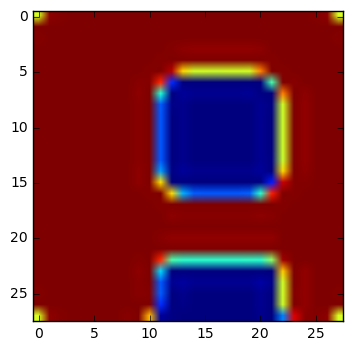

In [3]:
pickle_file = train_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)  # display it
    

In [6]:
#problem 3
for data_set in train_datasets:
    count = np.load(data_set).shape[0]
    print(count)

52909
52911
52912
52911
52912
52912
52912
52912
52912
52911


In [3]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [4]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [5]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

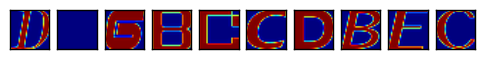

In [6]:
# Problem 4
f = plt.figure()
for i in range(0,10):
    plot = f.add_subplot(1,10,i+1)
    plt.imshow(train_dataset[i])
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Problem 5
i = 0
f = plt.figure()
for train_figure in train_dataset:
    for test_figure in test_dataset:
        if (np.equal(train_figure,test_figure).all()):
            i+=1
            if (i < 10):
                plot = f.add_subplot(1,20,2*i+1)
                plt.imshow(train_figure)
                plot.axes.get_xaxis().set_visible(False)
                plot.axes.get_yaxis().set_visible(False)
                plot = f.add_subplot(1,20,2*i+2)
                plt.imshow(test_figure)
                plot.axes.get_xaxis().set_visible(False)
                plot.axes.get_yaxis().set_visible(False)
            break
plt.show()
i

In [39]:
# Problem 6
model = lm.LogisticRegression()
size, nx, ny = test_dataset.shape
for n in (50, 100, 500, 2000):
    model = lm.LogisticRegression()
    reshaped_train_dataset = np.reshape(train_dataset[:n], (n, nx*ny))
    reshaped_train_labels = train_labels[:n].ravel()
    model.fit(reshaped_train_dataset, reshaped_train_labels)
    reshaped_test_dataset = np.reshape(test_dataset, (test_dataset.shape[0], nx*ny))
    reshaped_test_labels = test_labels.ravel()
    print("Training with %d samples, got accuracy %f" % (n, model.score(reshaped_test_dataset, reshaped_test_labels)))

Training with 50 samples, got accuracy 0.706000
Training with 100 samples, got accuracy 0.791500
Training with 500 samples, got accuracy 0.823000
Training with 2000 samples, got accuracy 0.838200


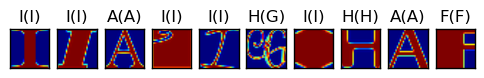

In [38]:
# Visualizing
def letter(i):
    return chr(ord('A')+i)
f = plt.figure()
for i in range(0,10):
    plot = f.add_subplot(1,10,i+1)
    plt.imshow(valid_dataset[i])
    plt.title(letter(model.predict(valid_dataset[i].ravel().reshape(1,-1))) + "(" + letter(valid_labels[i]) + ")")
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)
plt.show()